# Battle of the Neighborhoods
### Applied Data Science Capstone Project at Coursera

## Contents:
 - [Introduction](#introduction)   
 - [Data](#data)
  1. [Burbank](#burbank)  
  2. [Glendale](#glendale)  
  3. [Los Angeles (city)](#la)  
 - [Methodology](#methodology)  
 - [Analysis](#analysis)  
 - [Results](#results)  
 - [Discussion](#discussion)  
 - [Conclusion](#conclusion)  
 - [References](#references)  

## Introduction <a name="introduction"></a>

#### Finding a Unique Place to Eat in Burbank

**The Problem:** A hungry *person* in **Burbank** (California) wants to get food.  
**The Bigger Problem:** They’ve been to many places, and don’t want “the same old thing.”  
**The Biggest Problem:** Where to go?
  
Without a profile of venues a person has visited, how likely are they to find a **unique place** to eat in **Burbank**? Would they do better in neighboring **Glendale**? Or nearby **Los Angeles**?  
  
The problem of finding a unique place to eat becomes:  
1. __Rate of Opportunity:__ How many different choices are available? (And how close?)  
2. __Suggestions:__ Make a list of unique venues.


## Data <a name="data"></a>

In light of the two sub-categories of the problem, we will look at the data in different ways. 

Fortunately, we can use some of the same data:  
* using the **Foursquare API**, we collect information on various *food venues* and their respective category (eg. "American_Restaurant", etc)
* As the cities we are looking at are geographic neighbors, searching in a radius will not give usable results. We will use **zip codes** associated with each city to refine the food venues
* To determine Rate of Opportunity, we will require each city's **population** and **size**

We can also compare lists of *food venues* between cities to get unique food venue **suggestions** for each city.

#### Special Consideration  
There are 272 neighborhoods in *Los Angeles County*. To manage project scope, we are considering only three examples:  
* **Burbank** -- our city
* **Glendale** -- a comparable neighbor
* **Los Angeles City** -- a larger one

In [2]:
# consolidated imports (to avoid duplicate efforts)
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
!pip -q install geopy
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup as bsoup
import json
import requests

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

#from sklearn.cluster import KMeans
!pip -q install folium
import folium
import os
import pickle

print("Libraries imported.")

Libraries imported.


In [3]:
# @hidden_cell
#global CLIENT_ID, CLIENT_SECRET
CLIENT_ID = '2QYBGAH4SORUT0H1VZYOZ5YQ5PNU5EUKCMKSA2LDGJQ5PNOY'
CLIENT_SECRET = 'ACFLUQRPWK5YJBELFRLAGELDHGL440DU4HI1JQUNW2IVESUA'

##### Close Neighborhoods call for Small Search Areas  
Our search for food venues will be on Foursquare. We will be giving coordinates based on zip codes for each city. Since the centers of our search are located quite close to one another, we are setting a fairly small radius for each search.  
  
Setting a limit of 100 search results allows for some overlap of each search into neighboring zip code(s). We will refine our list after the searches.

In [4]:
# id & secret were set (above)
radius = 2500
VERSION = '20200402'
LIMIT = 100

## Burbank <a name="burbank"></a>

First on our agenda is getting information about **Burbank**. We start by getting getting a complete list of (standard) **Zip Codes** for the city.  
We are excluding specialized zip codes, as they are for P.O. boxes, etc, and do not represent where food venues might be located.

**Note**: as we will retrieving Zip Codes several times, we've written  a function for efficiency.

In [6]:
# returns of a list of zip codes for given community
def get_zip_codes(name=""):
    if (len(name) < 1): return []
    req = requests.get("https://www.zip-codes.com/city/ca-"+name+".asp")
    soup = bsoup(req.content,'lxml')
    table = soup.find_all('table')[2]
    df = pd.read_html(str(table))
    zcode_table = pd.DataFrame(df[0])
    zcode_table.columns = list(zcode_table.iloc[0,:])
    zcode_table.drop([0], axis=0, inplace=True)
    return list(zcode_table['ZIP Code'][zcode_table['Type']=='Standard'].str.replace('ZIP Code ',''))

Running to the API every time we run this is redundant -- this information doesn't change. So we're storing the information locally for speed in access.

In [7]:
city = 'Burbank'

#os.remove("b_zips.txt"); b_zips = None # This line for clearing data

# If available, use our existing data; otherwise, get it
if os.path.isfile("b_zips.txt"):
    with open("b_zips.txt", "rb") as fp:
        b_zips = pickle.load(fp)
    print("(from file)")
else:
    b_zips = get_zip_codes(city)
    with open("b_zips.txt", "wb") as fp:
        pickle.dump(b_zips, fp)
print(city,'Zip Codes ( 5 of',len(b_zips),')')
print(b_zips[:5])

Burbank Zip Codes ( 5 of 5 )
['91501', '91502', '91504', '91505', '91506']


### Geolocator  
Next, we build a table of **Zip Code** and **Latitude** and **Longitude**. Using this table, we can perform our food venue search -- and restrict our results to the relevant zip codes.  
For this, we use **Geopy**'s geolocator.  

In [8]:
geolocator = Nominatim(user_agent="foursquare_agent")


**Note**: For efficiency, we write this as a function.

In [9]:
# returns list([lat, lng]) for given list(zip), community
def get_lat_lng(zips=['91504'], name='Burbank'):
    tmp_locs = []
    for z in zips:
        tmp_loc1 = geolocator.geocode({z+', '+name+', California'})
        tmp_locs.append([tmp_loc1.latitude, tmp_loc1.longitude])
    return tmp_locs

Again, it's very slow to repeatedly ask for this information. We'll save it as a local file for quick access when we re-run this code.

In [10]:
# build dataframe of Burbank zip, lat, lng
#os.remove("burbank_locations.csv"); burbank_locations = None # This line for clearing data

# If available, use our existing data; otherwise, get it
if os.path.isfile("burbank_locations.csv"):
    burbank_locations = pd.read_csv("burbank_locations.csv")
    burbank_locations.set_index('Zip', inplace=True)
    burbank_locations.index = burbank_locations.index.map(str)
    print("(from file)")
else:
    tmp_coords = get_lat_lng(b_zips, city)
    burbank_locations = pd.DataFrame(columns=['Zip', 'Lat', 'Lng'])
    for i in range(len(b_zips)):
        burbank_locations.loc[i] = [b_zips[i], tmp_coords[i][0], tmp_coords[i][1]]
    burbank_locations.set_index('Zip', inplace=True)
    burbank_locations.to_csv("burbank_locations.csv")
print(burbank_locations.head(5))

             Lat         Lng
Zip                         
91501  34.192257 -118.307328
91502  34.179504 -118.313989
91504  34.193479 -118.332454
91505  34.167852 -118.344170
91506  34.172054 -118.322601


### Foursquare  
We have a table of the zip codes in Burbank, and the respective coordinates of each. We can now query Foursquare's API to get information on them.  
  
* **1.** Using a loop, we collect the venues for each zip code. Since we did not specify which *kind* of food our hungry stakeholder wants, we are casting the net wide -- restaurants, cafes, etc. Right now, the important thing is getting a lot of choices.  
  
* **2.** We now have a large table. But there are duplicate and un-related entries as well. As we are looking for **unqiue venues**, we drop the duplicate entries -- one representative per venue. (In other words, the "McDonalds" down the street is redundant to the one next door.)  
  
* **3.** We then keep the entries within our list of Burbank zip codes. Now we have a table of food venues **only** within Burbank.

**Note**: As this is fairly involved, we save the clean data locally for efficient retrieval. Secondarily, a sub-table turns into a string, which is easier to extract the data we need. (see below)

In [39]:
# get df of places to eat in Burbank
#os.remove("burbank_eats.csv"); burbank_eats = None # This line for clearing data

tmp_df = None
# If available, use our existing data; otherwise, make it
if not os.path.isfile("burbank_eats.csv"):
    for i in range(burbank_locations.shape[0]):
        [lat, lng] = burbank_locations.iloc[i]
        
        url= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId=4d4b7105d754a06374d81259&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT)
        results = requests.get(url).json()
        if (type(tmp_df) == type(None)):
            tmp_df = json_normalize(results['response']['venues'])
        else:
            tmp_df = tmp_df.append(json_normalize(results['response']['venues']))
    tmp_df.to_csv("burbank_eats.csv", index=False)

tmp_df1 = pd.read_csv("burbank_eats.csv")
# remove duplicates
print(tmp_df1.shape[0],"entries WITH duplicates")

tmp_df1.sort_values("name", inplace=True)
tmp_df2 = tmp_df1.drop_duplicates(subset ="name", keep = 'first')
print(tmp_df2.shape[0],"unique entries")

burbank_eats = tmp_df2[tmp_df2['location.postalCode'].isin(list(burbank_locations.index.values))]
burbank_eats = burbank_eats.copy()
print(burbank_eats.shape[0],"within",city,"zip codes")

print()
print(burbank_eats.head(1))

250 entries WITH duplicates
77 unique entries
66 within Burbank zip codes

                                          categories  delivery.id  \
0  [{'id': '4d954b0ea243a5684a65b473', 'name': 'C...          NaN   

  delivery.provider.icon.name delivery.provider.icon.prefix  \
0                         NaN                           NaN   

  delivery.provider.icon.sizes delivery.provider.name delivery.url  hasPerk  \
0                          NaN                    NaN          NaN    False   

                         id     location.address     ...       \
0  4bf1a3b6324cc9b61347cc92  600 N Glenoaks Blvd     ...        

                           location.formattedAddress  \
0  ['600 N Glenoaks Blvd (at E Cypress Ave)', 'Bu...   

                             location.labeledLatLngs location.lat  \
0  [{'label': 'display', 'lat': 34.1871433266839,...    34.187143   

  location.lng  location.neighborhood location.postalCode location.state  \
0    -118.3111                    NaN    

That is quite a change! By eliminating duplicates and restricting our results to the relevant zip codes, we reduce the list by almost 80%.  
  
But the table is still very messy, and contains columns with irrelevant information. For this investigation, we are not interested in a venue's location (beyond establishing that it's in our city), or its ratings (beyond the scope of this project), etc.  
  
So, let's **clean things up** even more.

**Note**: For consistency and efficiency of clean-up, we'll make a list of columns to drop. (This list will be used for all cities.)

In [43]:
columns_to_drop = list(['delivery.id', 'delivery.provider.icon.name', 'delivery.provider.icon.prefix', \
                'delivery.provider.icon.sizes', 'delivery.provider.name', 'delivery.url', 'hasPerk', \
                'location.crossStreet', 'location.distance', 'location.formattedAddress', 'location.labeledLatLngs', \
                'location.neighborhood', 'referralId', 'venuePage.id', 'location.address', 'location.cc', \
                'location.city', 'location.country', 'location.state', 'id'])
print(len(columns_to_drop),'columns will be dropped.')

20 columns will be dropped.


In [44]:
burbank_eats.drop(columns_to_drop, axis=1, inplace=True)
burbank_eats.head(5)

,categories,location.lat,location.lng,location.postalCode,name
0,"[{'id': '4d954b0ea243a5684a65b473', 'name': 'C...",34.187143,-118.311100,91502,7-Eleven
4,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",34.176736,-118.317826,91502,Acai Jungle Cafe
246,"[{'id': '4bf58dd8d48988d14e941735', 'name': 'A...",34.178920,-118.309514,91502,BJ's Restaurant & Brewhouse
22,"[{'id': '4bf58dd8d48988d1c9941735', 'name': 'I...",34.164993,-118.306134,91502,Baskin-Robbins
170,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",34.155728,-118.346311,91505,Bea Bea's


**Neater, but** the "categories" column is still a mess. We only need one piece of information from all of that -- the **name** of the venue's category.

Again, as we be re-using this code... we make it a function.

In [45]:
# returns a cleaned list of 'categories' from given dataframe
def clean_categories(df=pd.DataFrame()):
    tmp_cats =[]
    for cat in list(df['categories']):
        eat1 = cat.split()
        eat2 = "_".join(list(eat1[eat1.index("'name':")+1:eat1.index("'pluralName':")]))
        eat3 = eat2.replace("'", "").replace(",", "")
        tmp_cats.append(eat3)
    return tmp_cats

Also, let's clean up the column names while we're at it.

In [46]:
burbank_eats['categories'] = clean_categories(burbank_eats)
burbank_eats.columns = ['Category', 'Lat', 'Lng', 'Zip_Code', 'Name']
burbank_eats.head(5)

,Category,Lat,Lng,Zip_Code,Name
0,Convenience_Store,34.187143,-118.311100,91502,7-Eleven
4,Café,34.176736,-118.317826,91502,Acai Jungle Cafe
246,American_Restaurant,34.178920,-118.309514,91502,BJ's Restaurant & Brewhouse
22,Ice_Cream_Shop,34.164993,-118.306134,91502,Baskin-Robbins
170,Breakfast_Spot,34.155728,-118.346311,91505,Bea Bea's


Now that's **a clean-looking table**. Every venue in Burbank is represented, along with its category. We also have the zip code, and geographical coordinates.  
  
**Note**: The table does not account for a person's taste. You can actually get food at "7-Eleven" (Surprise!) But now we have content to discuss.

### What Does it Mean?  
  
Let's drill down a little bit more into this data. If we group the venues by **category**, we can find out how similar they are.

In [47]:
burbank_eat_type = burbank_eats.groupby(['Category']).count()
burbank_eat_type.rename(columns={'Lat': 'count'}, inplace=True)
burbank_eat_type.drop(['Lng','Zip_Code','Name'], axis=1, inplace=True)

print(burbank_eat_type.head(5))
print()
print(burbank_eat_type.shape[0],'Category')
print('from',burbank_eats.shape[0],'venues')

                     count
Category                  
American_Restaurant      6
Asian_Restaurant         3
BBQ_Joint                1
Breakfast_Spot           1
Bubble_Tea_Shop          1

32 Category
from 66 venues


Rather than make a really long list, let's look at this data another way.

Text(0.5,0,'Number of Venues in Category')

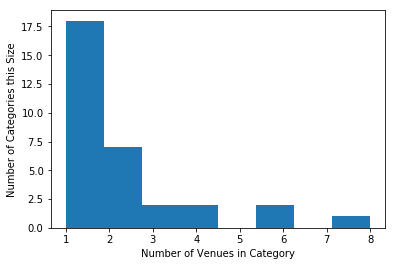

In [48]:
bins=8
plt.hist(burbank_eat_type['count'], bins=bins)
plt.ylabel('Number of Categories this Size')
plt.xlabel('Number of Venues in Category')

Looks like most of the categories have only one or two venues. This is good, as it means **more uniqueness among venues**.

### Rate of Opportunity  
Now, let's look at the rate of opportunity for our hungry person.  
  
There are two ways to consider this:
1. As **one person** in a population going to one venue, what is the opportunity for that person encountering a unqiue venue?
2. As one person **in an area** the size of Burbank, what is the opportunity for that person to encounter a unique venue?

Let's begin by getting a table of the population (for all three cities.)

In [49]:
# get population
#os.remove("pop_df.csv"); pop_df = None # This line for clearing data

# If available, use our existing data; otherwise, get it
if os.path.isfile("pop_df.csv"):
    pop_df = pd.read_csv("pop_df.csv")
    print("(from file)")
else:
    req = requests.get("https://en.wikipedia.org/wiki/Los_Angeles_County,_California")
    soup = bsoup(req.content,'lxml')
    table = soup.find_all('table')[10]
    pop_df = pd.read_html(str(table))[0]
    pop_df.columns = pop_df.iloc[0,:]
    # clean up the "dagger" in the first column
    pop_df.loc[:, 'City/Town/etc.'].replace(regex=True, to_replace="† ", value="", inplace=True)
    pop_df.to_csv("pop_df.csv", index=False)
pop_df.head(5)

(from file)


,Rank,City/Town/etc.,Municipal type,Population (2010 Census)
0,Rank,City/Town/etc.,Municipal type,Population (2010 Census)
1,1,Los Angeles,City,3792621
2,2,Long Beach,City,462257
3,3,Glendale,City,191719
4,4,Santa Clarita,City,176320


Let's also get a table of the size of (all three) cities.

In [50]:
# get land area
#os.remove("sqr_mi_df.csv"); sqr_mi_df = None # This line for clearing data

# If available, use our existing data; otherwise, get it
if os.path.isfile("sqr_mi_df.csv"):
    sqr_mi_df = pd.read_csv("sqr_mi_df.csv")
    print("(from file)")
else:
    req = requests.get("http://maps.latimes.com/neighborhoods/area/square-miles/neighborhood/list/")
    soup = bsoup(req.content,'lxml')
    table = soup.find_all('table')[1]
    sqr_mi_df = pd.read_html(str(table))[0]
    sqr_mi_df.to_csv("sqr_mi_df.csv", index=False)
sqr_mi_df.head(5)

(from file)


,Rank,Neighborhood,Square Miles
0,1,Northeast Antelope Valley,442.0
1,2,Angeles Crest,430.5
2,3,Ridge Route,292.7
3,4,Tujunga Canyons,229.9
4,5,Northwest Antelope Valley,213.9


A quick peek at Burbank data...

In [51]:
# population
burbank_pop = list(pop_df['Population (2010 Census)'][pop_df['City/Town/etc.']==city])[0]
print(city,"Population=",burbank_pop)

# area
burbank_sqr_mi = list(sqr_mi_df['Square Miles'][sqr_mi_df['Neighborhood']==city])[0]
print(city,"Square Miles=",burbank_sqr_mi)

Burbank Population= 103340
Burbank Square Miles= 17.3


Let's see what information we have so far.

In [52]:
# count the unique places to eat
burbank_eats_num = burbank_eats.shape[0]
print(city,"Unique Food Venues =",burbank_eats_num)

burbank_categories = len(list(burbank_eats['Category'].unique()))
print(city,"Unique Types of Venues =",burbank_categories)

# Uniq / Pop
print(city,"Venues / Person =",burbank_eats_num / int(burbank_pop))

# Uniq / Sqr Mile
print(city,"Venues / Sqr Mile =",burbank_eats_num / burbank_sqr_mi)

Burbank Unique Food Venues = 66
Burbank Unique Types of Venues = 32
Burbank Venues / Person = 0.0006386684730017418
Burbank Venues / Sqr Mile = 3.8150289017341037


### Burbank summary

With 66 Unique Venues in 32 Categories, it looks like our hungry person has an **Opportunity Rate**:  
1. of 0.0006 (about 0.06%) as an individual finding a unique venue
2. of 3.82 venues per square mile

That's all very nice, but what does it **mean**?  
  
Without a bigger context, there's not much to go on.

**Burbank map**  
  
Let's look at those venues on a map of Burbank to see where our opportunity lies.  
  
**Note**: Burbank is bounded by a dashed line.

In [53]:
# create Burbank map
lat = burbank_locations['Lat'].mean()
lng = burbank_locations['Lng'].mean()

map_burbank = folium.Map(location=[lat, lng], tiles='OpenStreetMap', zoom_start=12, \
                    max_zoom=14, min_zoom=10)

#, zoom_control=False
for place, zipc, lat, lng in \
        zip(burbank_eats['Name'], burbank_eats['Zip_Code'], \
            burbank_eats['Lat'], burbank_eats['Lng']):
    label = folium.Popup(place, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#31cc86',
        fill_opacity=0.7,
        parse_html=False).add_to(map_burbank)
map_burbank

Here's a (non-interactive) rendering of the above map.

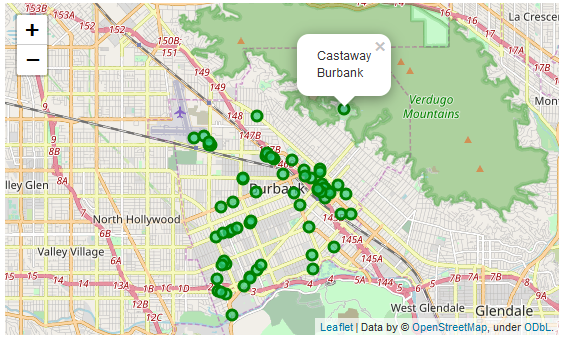

As we can see, the **venues / square mile** doesn't apply equally. Imagine being at the **Castaway Burbank**, and wanting another choice. The Opportunity Rate is only good as an average guide.

## Glendale <a name="glendale"></a>  
  
Moving on, let's look at Glendale to gain a little perspective. As we'll see on the map(above, or further below), it is located next to Burbank, so this is a neighborly comparison.

We start by gathering the Zip Codes.

In [54]:
city = 'Glendale'
#os.remove("g_zips.txt"); g_zips = None # This line for clearing data

# If available, use our existing data; otherwise, get it
if os.path.isfile("g_zips.txt"):
    with open("g_zips.txt", "rb") as fp:
        g_zips = pickle.load(fp)
    print("(from file)")
else:
    g_zips = get_zip_codes(city)
    with open("g_zips.txt", "wb") as fp:
        pickle.dump(g_zips, fp)
print(city,'Zip Codes ( 5 of',len(g_zips),')')
print(g_zips[:5])

Glendale Zip Codes ( 5 of 10 )
['91201', '91202', '91203', '91204', '91205']


There are 10 Zip Codes in Glendale, compared with Burbank's 5.  
  
Let's build the table of coordinates.

In [55]:
# build dataframe of Glendale zip, lat, lng
#os.remove("glendale_locations.csv"); glendale_locations = None # This line for clearing data

# If available, use our existing data; otherwise, get it
if os.path.isfile("glendale_locations.csv"):
    glendale_locations = pd.read_csv("glendale_locations.csv")
    glendale_locations.set_index('Zip', inplace=True)
    glendale_locations.index = glendale_locations.index.map(str)
    print("(from file)")
else:
    tmp_coords = get_lat_lng(g_zips, city)
    glendale_locations = pd.DataFrame(columns=['Zip','Lat', 'Lng'])
    for i in range(len(g_zips)):
        glendale_locations.loc[i] = [g_zips[i], tmp_coords[i][0], tmp_coords[i][1]]
    glendale_locations.set_index('Zip', inplace=True)
    glendale_locations.to_csv("glendale_locations.csv")
print(glendale_locations.head(5))

             Lat         Lng
Zip                         
91201  34.146942 -118.247847
91202  34.162996 -118.262668
91203  34.151273 -118.257486
91204  34.146942 -118.247847
91205  34.146942 -118.247847


Next, we get a table of venues from **Foursquare**, as we did before.  
  
**Note**: Due to problems implementing this code as a function, we are writing (virtually the same) the code again. Inefficient, but functioning.

In [56]:
# get df of places to eat in Glendale
#os.remove("glendale_eats.csv"); glendale_eats = None # This line for clearing data

tmp_df = None
# If available, use our existing data; otherwise, make it
if not os.path.isfile("glendale_eats.csv"):
    for i in range(glendale_locations.shape[0]):
        [lat, lng] = glendale_locations.iloc[i]
        
        url= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId=4d4b7105d754a06374d81259&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT)
        results = requests.get(url).json()
        if (type(tmp_df) == type(None)):
            tmp_df = json_normalize(results['response']['venues'])
        else:
            tmp_df = tmp_df.append(json_normalize(results['response']['venues']))
    tmp_df.to_csv("glendale_eats.csv", index=False)

tmp_df1 = pd.read_csv("glendale_eats.csv")
# remove duplicates
print(tmp_df1.shape[0],"entries WITH duplicates")

tmp_df1.sort_values("name", inplace=True)

tmp_df2 = tmp_df1.drop_duplicates(subset ="name", keep = 'first')
print(tmp_df2.shape[0],"unique entries")

glendale_eats = tmp_df2[tmp_df2['location.postalCode'].isin(g_zips)]
glendale_eats = glendale_eats.copy()
print(glendale_eats.shape[0],"within",city,"zip codes")

glendale_eats.drop(columns_to_drop, axis=1, inplace=True)
glendale_eats['categories'] = clean_categories(glendale_eats)
glendale_eats.columns = ['Category', 'Lat', 'Lng', 'Zip_Code', 'Name']
print()
glendale_eats.head(5)

492 entries WITH duplicates
148 unique entries
102 within Glendale zip codes



,Category,Lat,Lng,Zip_Code,Name
253,Convenience_Store,34.142136,-118.264643,91204,7-Eleven
69,Bakery,34.148222,-118.255239,91203,85C Bakery Cafe
477,Restaurant,34.239311,-118.265204,91214,Aiden's Grill
456,Pizza_Place,34.237475,-118.262099,91214,Ameci Pizza Kitchen
347,American_Restaurant,34.146462,-118.255193,91203,BJ's Restaurant & Brewhouse


From all of those raw entries, we refined the table to the 25% that are unique venues. We now have a concise and clean table of unique food venues in Glendale.  
  
How many categories are there?

In [57]:
glendale_eat_type = glendale_eats.groupby(['Category']).count()
glendale_eat_type.rename(columns={'Lat': 'count'}, inplace=True)
glendale_eat_type.drop(['Lng','Zip_Code','Name'], axis=1, inplace=True)

print(glendale_eat_type.head())
print()
print(glendale_eat_type.shape[0],"Categories")

                     count
Category                  
American_Restaurant      4
Bakery                  10
Bookstore                1
Breakfast_Spot           3
Bubble_Tea_Shop          1

44 Categories


Interesting. There are more categories, including (of all things) a "Bookstore".  
(Apparently, now even **bookworms** have a venue to eat at.)  
  
Let's look at how these venues are distributed.

Text(0.5,0,'Number of Venues in Category')

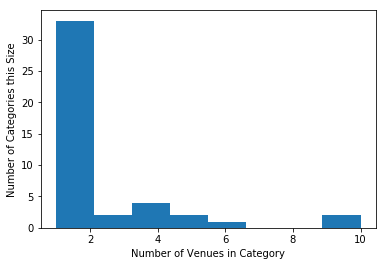

In [58]:
bins=8
plt.hist(glendale_eat_type['count'], bins=bins)
plt.ylabel('Number of Categories this Size')
plt.xlabel('Number of Venues in Category')

There are a lot more single-venue categories, as well as more low-count categories.  
  
Perhaps our hungry person is better off searching in Glendale. Let's see how they would fare.

### Rate of Opportunity  
  
How populous and how big is Glendale?

In [59]:
# population
glendale_pop = list(pop_df['Population (2010 Census)'][pop_df['City/Town/etc.']==city])[0]
print(city,"Population=",glendale_pop)

# area
glendale_sqr_mi = list(sqr_mi_df['Square Miles'][sqr_mi_df['Neighborhood']==city])[0]
print(city,"Square Miles=",glendale_sqr_mi)

Glendale Population= 191719
Glendale Square Miles= 30.6


As it turns out, Glendale has nearly twice the population, and just under twice the area of Burbank. It makes sense that there ae more opportunities there. Let's look at the rates.

In [61]:
# count the unique places to eat
glendale_eats_num = glendale_eats.shape[0]
print(city,"Unique Venues to Eat =",glendale_eats_num)

glendale_categories = len(list(glendale_eats['Category'].unique()))
print(city,"Unique Types of Venues =",glendale_categories)

# Uniq / Pop
print(city,"Venues / Person=",glendale_eats_num / int(glendale_pop))

# Uniq / Sqr Mile
print(city,"Venues / Sqr Mile=",glendale_eats_num / glendale_sqr_mi)

Glendale Unique Venues to Eat = 102
Glendale Unique Types of Venues = 44
Glendale Venues / Person= 0.000532028646091415
Glendale Venues / Sqr Mile= 3.333333333333333


### Glendale summary  
With 102 Unique Venues in 44 Categories, it looks like our hungry individual has an **Opportunity Rate**:  
1. of 0.0005 (about 0.05%) as an individual finding a unique venue
2. of 3.33 venues per square mile

Let's see what this looks like **on a map**.

In [62]:
# create Glendale map
lat = glendale_locations['Lat'].mean()
lng = glendale_locations['Lng'].mean()

map_glendale = folium.Map(location=[lat, lng], tiles='OpenStreetMap', zoom_start=11, \
                    max_zoom=13, min_zoom=9)

for place, zipc, lat, lng in \
        zip(glendale_eats['Name'], glendale_eats['Zip_Code'], \
            glendale_eats['Lat'], glendale_eats['Lng']):
    label = folium.Popup(place, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_glendale)
map_glendale

Because Glendale is larger, the above map is more zoomed out. Below is a (cropped) rendering, showing the dashed line of Glendale's boundaries.  

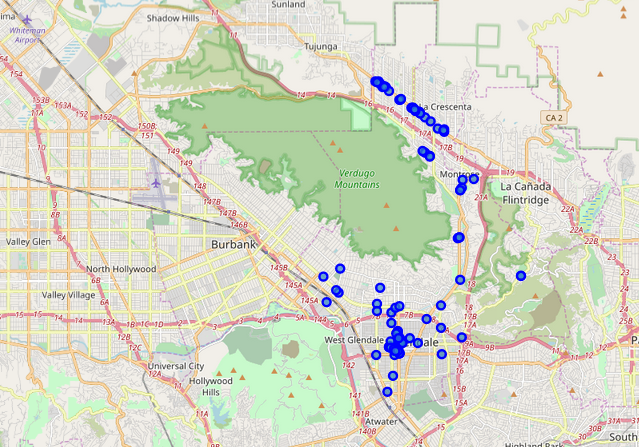

## Los Angeles <a name="la"></a>  
  
When we speak of Los Angeles, we are talking about the **city**, not the *county*. The county encompasses both Burbank and Glendale, as well as 270 other neighborhoods.  
Even so, the city is large by comparison.

In [63]:
city = "los-angeles"
#os.remove("la_zips.txt"); la_zips = None
if os.path.isfile("la_zips.txt"):
    with open("la_zips.txt", "rb") as fp:
        la_zips = pickle.load(fp)
    print("(from file)")
else:
    la_zips = get_zip_codes(city)
    with open("la_zips.txt", "wb") as fp:
        pickle.dump(la_zips, fp)
print(la_zips[:5],"of",len(la_zips))

['90001', '90002', '90003', '90004', '90005'] of 65


In [64]:
# build dataframe of L.A. zip, lat, lng
#os.remove("la_locations.csv"); la_locations = None # This line for clearing data

# If available, use our existing data; otherwise, get it
if os.path.isfile("la_locations.csv"):
    la_locations = pd.read_csv("la_locations.csv")
    la_locations.set_index('Zip', inplace=True)
    la_locations.index = la_locations.index.map(str)
    print("(from file)")
else:
    tmp_coords = get_lat_lng(la_zips, city)
    la_locations = pd.DataFrame(columns=['Zip','Lat', 'Lng'])
    for i in range(len(la_zips)):
        la_locations.loc[i] = [la_zips[i], tmp_coords[i][0], tmp_coords[i][1]]
    la_locations.set_index('Zip', inplace=True)
    la_locations.to_csv("la_locations.csv")
print(la_locations.head())

             Lat         Lng
Zip                         
90001  34.053691 -118.242767
90002  33.942374 -118.242424
90003  33.982475 -118.265706
90004  34.053691 -118.242767
90005  34.053691 -118.242767


Because L.A. is **bigger**, we increase the request limit and radius of search ... it makes a difference

In [66]:
# get df of places to eat in L.A.
#os.remove("la_eats.csv"); la_eats = None # This line for clearing data

LIMIT=200
radius=6000

tmp_df = None
# If available, use our existing data; otherwise, make it
if not os.path.isfile("la_eats.csv"):
    for i in range(la_locations.shape[0]):
        [lat, lng] = la_locations.iloc[i]
        
        url= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId=4d4b7105d754a06374d81259&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT)
        results = requests.get(url).json()
        if (type(tmp_df) == type(None)):
            tmp_df = json_normalize(results['response']['venues'])
        else:
            tmp_df = tmp_df.append(json_normalize(results['response']['venues']))
    tmp_df.to_csv("la_eats.csv", index=False)

tmp_df1 = pd.read_csv("la_eats.csv")
# remove duplicates
print(tmp_df1.shape[0],"entries WITH duplicates")

tmp_df1.sort_values("name", inplace=True)
tmp_df2 = tmp_df1.drop_duplicates(subset ="name", keep = 'first')
print(tmp_df2.shape[0],"unique entries")

la_eats = tmp_df2[tmp_df2['location.postalCode'].isin(la_zips)]
la_eats = la_eats.copy()
print(la_eats.shape[0],"within",city,"zip codes")

la_eats.drop(columns_to_drop, axis=1, inplace=True)
la_eats['categories'] = clean_categories(la_eats)
la_eats.columns = ['Category', 'Lat', 'Lng', 'Zip_Code', 'Name']
print()
la_eats.head(5)
#print(la_eats.head())

3250 entries WITH duplicates
353 unique entries
200 within los-angeles zip codes



,Category,Lat,Lng,Zip_Code,Name
651,Convenience_Store,34.052854,-118.313999,90019,7-Eleven
2476,Pizza_Place,34.040181,-118.253402,90015,9th Street Pizza
3230,Coffee_Shop,34.003252,-118.434948,90066,Alana's Coffee Roasters
1028,Coffee_Shop,34.060139,-118.291341,90005,Alchemist Coffee Project
2160,Coffee_Shop,34.083515,-118.374341,90069,Alfred Coffee & Kitchen


As we might expect, there are a lot more results. But notice dramatically how the number of raw entries diminishes when we eliminate duplicates.  
  
Should we expect more categories? Or just bigger ones?

In [67]:
la_eat_type = la_eats.groupby(['Category']).count()
la_eat_type.rename(columns={'Lat': 'count'}, inplace=True)
la_eat_type.drop(['Lng','Zip_Code','Name'], axis=1, inplace=True)
print(la_eat_type.head())
print(la_eat_type.shape[0],"category")

                     count
Category                  
American_Restaurant      8
Asian_Restaurant         4
BBQ_Joint                1
Bagel_Shop               1
Bakery                   8
65 category


Text(0.5,0,'Number of Places in Category')

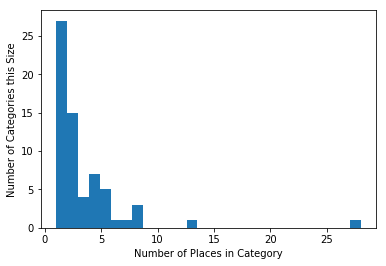

In [68]:
hist1 = plt.hist(la_eat_type['count'], bins=la_eat_type['count'].max())
plt.ylabel('Number of Categories this Size')
plt.xlabel('Number of Places in Category')

There are a lot of low-count categories. This is a good thing.  
  
Let's see how our hungry person how they would fare in L.A.

In [69]:
# population
la_pop = list(pop_df['Population (2010 Census)'][pop_df['City/Town/etc.']==city.title().replace("-"," ")])[0]
print(city,"Population=",la_pop)

# area - because our table does not contain the whole city, this is hard-coded
# courtesy: https://en.wikipedia.org/wiki/Los_Angeles
la_sqr_mi=468.67
print(city,"Square Miles=",la_sqr_mi)

los-angeles Population= 3792621
los-angeles Square Miles= 468.67


In [71]:
# count the unique places to eat
la_eats_num = la_eats.shape[0]
print(city,"Unique Food Venues =",la_eats_num)

la_categories = len(list(la_eats['Category'].unique()))
print(city,"Unique Types of Venues =",la_categories)

# Uniq / Pop
print(city,"Venues / Person=",la_eats_num / int(la_pop))

# Uniq / Sqr Mile
print(city,"Venues / Sqr Mile=",la_eats_num / la_sqr_mi)

los-angeles Unique Food Venues = 200
los-angeles Unique Types of Venues = 65
los-angeles Venues / Person= 5.2733980010130194e-05
los-angeles Venues / Sqr Mile= 0.42673949687413315


### L.A. summary  
With 200 Unique Venues in 65 Categories, it looks like our hungry person has an **Opportunity Rate**:  
1. of 0.00005 (about 0.005%) as an individual finding a unique venue
2. of 0.43 venues per square mile

**On the map**  
  
Let's look at those venues on a map, showing Burbank, Glendale, and Los Angeles.

Now we have a better context of the overall geography. We can also see each city's venue locations.

In [76]:
# create Combination map
lat = la_locations['Lat'].mean()
lng = la_locations['Lng'].mean()

map_la = folium.Map(location=[lat, lng], tiles='OpenStreetMap', zoom_start=10, \
                    max_zoom=12, min_zoom=8)

# draw L.A. markers
for place, zipc, lat, lng in \
        zip(la_eats['Name'], la_eats['Zip_Code'], \
            la_eats['Lat'], la_eats['Lng']):
    label = folium.Popup(place, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#cc8631',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)
# draw Glendale markers
for place, zipc, lat, lng in \
        zip(glendale_eats['Name'], glendale_eats['Zip_Code'], \
            glendale_eats['Lat'], glendale_eats['Lng']):
    label = folium.Popup(place, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)
# draw Burbank markers
for place, zipc, lat, lng in \
        zip(burbank_eats['Name'], burbank_eats['Zip_Code'], \
            burbank_eats['Lat'], burbank_eats['Lng']):
    label = folium.Popup(place, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#31cc86',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)
map_la

**Note**: the embedded image below is a rendering of the interactive map above.

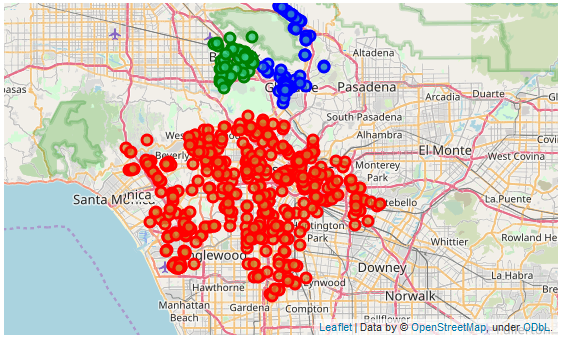

In this context, Burbank venues look very near each other. Glendale venues are also clustered, although in two groups. L.A. is a bit more fragmented.  
  
If we were just looking at the distances between venues, now would be a good place to do a K-means clustering to compare custers of venues.  
  
However, that isn't the aim here. We are trying to **find a unique food venue in Burbank**, and to compare the Rate of Opportunity between these three cities.

## Methodology <a name="methodology"></a>

In this project, we are trying to find "somewhere different" to eat in Burbank. For context, we compare the neighboring city, Glendale, and a much larger neighbor, Los Angeles (city.)  
  
Our _first step_ for each city was to **collect the data**.
  * We made a list of zip codes, compiled a table of the geographical coordinates (latitude, longitude) for each zip code, and performed a search on Foursquare for food venues near those coordinates.
  * We narrowed that list to single representatives of each venue, so that franchaises appear only once.
  * Because our search was spread wide (centered around a zip code, not **in** the zip code), we refined the list so that only venues in the city's zip codes were included.
  * We also collected **population** and **area** data.  
  
The _second step_ for each city was to explore what that data meant. We calculated **Rate of Opportunity** (both in terms of a person finding any given venue, and in terms of venue availability.) For **context**, we looked at maps presenting the three cities with their venues.  
  
At this point, we **could** have used K-Means clustering to analyze the locations of the venues in each city. However, as our data set includes (and is only looking for) **unique** venues, clustering them would not be well-served. Early on, many of the potential venues were reduced to single representatives. While this refinement helped our search, it skews the overall dataset.

The _third step_ will be to analyze the opportunities in each city. We will also compare venue lists between cities, and narrow them down to venues that appear uniquely in a given city.

## Analysis <a name="analysis"></a>

### Rate of Opportunity  

Earlier, we assessed Burbank in terms of population and area. At the time, we did not have any context, so there was no way of knowing whether the statistics were good or bad. Now that we have the same data on Glendale and Los Angeles, we are in a much better position to extract useful meaning out of this data.

In [78]:
# build a table of city statistics,
#    and calculate Rates of Opportunity
city_stats = pd.DataFrame({'City': ['Burbank', 'Glendale', 'Los_Angeles'], 
                    'Count_Venues': [burbank_eats_num, glendale_eats_num, la_eats_num], 
                    'Population': [int(burbank_pop), int(glendale_pop), int(la_pop)], 
                    'Area': [burbank_sqr_mi, glendale_sqr_mi, la_sqr_mi]})
city_stats.set_index('City',inplace=True)
city_stats['Venues_SqMile']=city_stats['Count_Venues']/city_stats['Area']
city_stats['Venues_Person']=city_stats['Count_Venues']/city_stats['Population']
city_stats.head()

,Area,Count_Venues,Population,Venues_SqMile,Venues_Person
City,,,,,
Burbank,17.30,66,103340,3.815029,0.000639
Glendale,30.60,102,191719,3.333333,0.000532
Los_Angeles,468.67,200,3792621,0.426739,0.000053


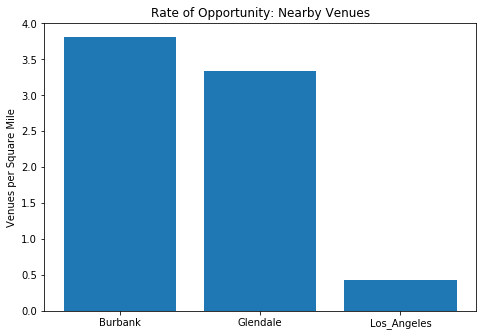

In [79]:
# graph city's venue opportunity
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(city_stats.index,city_stats['Venues_SqMile'])
ax.set_ylabel('Venues per Square Mile')
ax.set_title('Rate of Opportunity: Nearby Venues')
plt.show()

The **Rate of Opportunity** for a person looking for a **nearby venue** is best in Burbank.  
Our hungry individual is searching in the best neighborhood (of the three.)  
  
**Caveat:** as noted before, this is an **average**. A quick look at the Burbank map will reveal this to not be equally true in every part of the city.

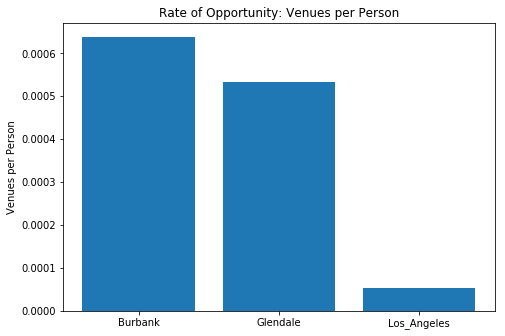

In [80]:
# graph city's venue opportunity
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(city_stats.index,city_stats['Venues_Person'])
ax.set_title('Rate of Opportunity: Venues per Person')
ax.set_ylabel('Venues per Person')
plt.show()

Likewise, the **Rate of Opportunity** for **one person** trying to find **a unique food venue** (amongst all available venues) is best in Burbank.   
  
Another **caveat:** just because a person **can**, does not guarantee that they **will**. It's just more likely.

## Results <a name="results"></a>

### Venue Suggestions  

The **other**, and arguably **more important**, part of problem takes our analysis from the theoretical to the practical: we need a list of actual venues to consider.  
  
Fortunately, we can leverage our existing data to do this.

Previously, we narrowed our city's lists to only unqiue venues. We graphed the number of venues in each Category, and saw high numbers of **single-entry Categories**.  
  
We now refine each city's venue list to **only** include single-entry categories. If there is a single entry in a category, it is more unique than a group in a category. (For example, one venue in category:"fish" is more unique than the five venues in category:"hamburger.")

In [98]:
unique_burbank_eat_type = list(burbank_eat_type.index[burbank_eat_type['count']==1])
unique_burbank_eats = burbank_eats[burbank_eats['Category'].isin(unique_burbank_eat_type)]
print('Unique Food Venues in Burbank ( 5 of',unique_burbank_eats.shape[0],')')
unique_burbank_eats.head(5)

Unique Food Venues in Burbank ( 5 of 18 )


,Category,Lat,Lng,Zip_Code,Name
0,Convenience_Store,34.187143,-118.311100,91502,7-Eleven
22,Ice_Cream_Shop,34.164993,-118.306134,91502,Baskin-Robbins
170,Breakfast_Spot,34.155728,-118.346311,91505,Bea Bea's
33,New_American_Restaurant,34.181887,-118.311156,91502,Boiling Crab Burbank
45,Wings_Joint,34.181845,-118.311495,91502,Buffalo Wild Wings


In [99]:
unique_glendale_eat_type = list(glendale_eat_type.index[glendale_eat_type['count']==1])
unique_glendale_eats = glendale_eats[glendale_eats['Category'].isin(unique_glendale_eat_type)]
print('Unique Food Venues in Glendale ( 5 of',unique_glendale_eats.shape[0],')')
unique_glendale_eats.head(5)

Unique Food Venues in Glendale ( 5 of 21 )


,Category,Lat,Lng,Zip_Code,Name
253,Convenience_Store,34.142136,-118.264643,91204,7-Eleven
334,Bookstore,34.143741,-118.256744,91210,Barnes & Noble
463,Kebab_Restaurant,34.226475,-118.243898,91214,Byblos Mediterranean Bakery
40,Steakhouse,34.150639,-118.255338,91203,Damon's Steak House
325,Dumpling_Restaurant,34.143124,-118.255027,91210,Din Tai Fung


In [100]:
unique_la_eat_type = list(la_eat_type.index[la_eat_type['count']==1])
unique_la_eats = la_eats[la_eats['Category'].isin(unique_la_eat_type)]
print('Unique Food Venues in Los Angeles ( 5 of',unique_la_eats.shape[0],')')
unique_la_eats.head(5)

Unique Food Venues in Los Angeles ( 5 of 27 )


,Category,Lat,Lng,Zip_Code,Name
651,Convenience_Store,34.052854,-118.313999,90019,7-Eleven
1598,Pub,33.976737,-118.417921,90094,Astro Pub
2834,Creperie,34.039700,-118.429594,90064,Chocolate Bash
1086,Bar,34.044872,-118.249489,90014,Cole's
1609,Gourmet_Shop,34.059960,-118.419036,90067,Eataly


Now we have a list of **categorically** unique food venues for each city. Only one step left to do -- eliminate venues with the same category as the other cities.

In [133]:
all_burbank_cats = set(burbank_eats['Category'])
all_glendale_cats = set(glendale_eats['Category'])
all_la_cats = set(la_eats['Category'])
all_bbk_gln_cats = b_cats.union(g_cats)

# for L.A.
uniquely_la = unique_la_eats[['Category', 'Name']][unique_la_eats['Category'].isin(list(set(all_la_cats.difference(all_bbk_gln_cats))))]
print(uniquely_la.head(10).to_string(index=False))
print()
print('10 of',uniquely_la.shape[0],'uniquely Los Angeles venues.')

Category                   Name
              Pub              Astro Pub
         Creperie         Chocolate Bash
              Bar                 Cole's
     Gourmet_Shop                 Eataly
        Gastropub        Father’s Office
      Supermarket        Gelson's Market
           Market   Grand Central Market
       Hookah_Bar            Habibi Cafe
Health_Food_Store  Lassens Natural Foods
             Food              Lupe’s #2

10 of 20 uniquely Los Angeles venues.


There are still a **lot** of unique venues in Los Angeles.

In [135]:
# for Glendale
uniquely_glendale = unique_glendale_eats[['Category', 'Name']][unique_glendale_eats['Category'].isin(list(set(all_glendale_cats.difference(all_la_cats)).difference(all_burbank_cats)))]
print(uniquely_glendale.to_string(index=False))
print()
print('All of the uniquely Glendale venues.')

Category                         Name
          Bookstore               Barnes & Noble
   Kebab_Restaurant  Byblos Mediterranean Bakery
Dumpling_Restaurant                 Din Tai Fung
             Buffet          FUJi Buffet & Grill
         Poke_Place          Glendale Poke House
Filipino_Restaurant              Max's of Manila
   Halal_Restaurant               The Halal Guys
      Hot_Dog_Joint              Wienerschnitzel

All of the uniquely Glendale venues.


The list is shorter for Glendale. But, according to our **Rate of Opportunity**, Burbank is the most likely place to actually locate a unique food venue.

In [136]:
# for Burbank
uniquely_burbank = unique_burbank_eats[['Category', 'Name']][unique_burbank_eats['Category'].isin(list(set(all_burbank_cats.difference(all_la_cats)).difference(all_glendale_cats)))]
print(uniquely_burbank.to_string(index=False))
print()
print('All of the uniquely Burbank venues.')

Category                Name
            Wings_Joint  Buffalo Wild Wings
          Burrito_Place      Corner Cottage
Scandinavian_Restaurant     IKEA Restaurant

All of the uniquely Burbank venues.


## Discussion <a name="discussion"></a>

In exploring the data, we discovered that there are a **lot** of food venues in Burbank, Glendale, and Los Angeles. Between the three cities, there are approximately 4000. With a combined population of nearly 4 million people, and covering an area over 500 square miles, **finding a unique food venue** can be a problem.  
  
We narrowed the list of venues for each city to eliminate duplicate names (which kept a single representative for chains.) We further refined our lists by keeping only categorically-solitary venues. Then we cross-referenced the lists between cities, which gave us the food venues uniquely in each city.

By evaluating venue availability to population and area, we were able to determine the Rate of Opportunity within each city. We then compared the rates between cities to establish the most likely city to have a unique food venue.  
  
Of course, these results are only as good as the data they were derived from. Also, the rate of opportunity uses averages. But this gives us a good foundation.  

Based on the process we've gone through, our recommended food venues in **Burbank** are:
* Buffalo Wild Wings -- if you like Wings
* Corner Cottage -- for Burritos
* IKEA Restaurant -- to get furniture and Scandinavian food

## Conclusion <a name="conclusion"></a>

The purpose of this project was to **help our hungry person find a food venue that was NOT "the same old thing."** To do this, we broke the problem into two components:  
     1. Identify the **Rates of Opportunity** to locate a unique food venue for Burbank and its neighboring cities, Glendale and Los Angeles.  
     2. Generate a list of suggested unique food venues.  

Who would guess that **"Scandinavian Restaurant"** might be a food venue uniquely in Burbank?

## References <a name="references"></a>

The following were used in gathering data:  
[Communities in San Fernando Valley](https://en.wikipedia.org/wiki/Category:Communities_in_the_San_Fernando_Valley) for determining neighboring cities  
[Zip Codes.com](https://www.zip-codes.com/) to collect **zip codes** per city  
[Geopy](https://geopy.readthedocs.io/en/stable/) for determining geographic **coordinates** (latitude, longitude) of each zip code  
[Foursquare](https://api.foursquare.com) to collect **food venues** and associated **categories**  
[Los Angeles County](https://en.wikipedia.org/wiki/Los_Angeles_County,_California) for **population** of each city  
[Los Angeles Neighborhoods](http://maps.latimes.com/neighborhoods/area/square-miles/neighborhood/list/) for **size** of each city  